In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import random


def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = '/'+string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


train_category_lines = {}
test_category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('../../content/drive/My Drive/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    nd = np.array(lines)
    print("Category {:10} | #names :{:5} | #unique names : {:5} | #redundancy names : {:5} | Redundancy rate {:.2f}%".format(category,len(lines),np.unique(nd).shape[0],
                                                                                    len(lines)-np.unique(nd).shape[0],100* (len(lines)-np.unique(nd).shape[0])/len(lines)))
    
    # Delete duplicated names
    lines = np.unique(nd).tolist()
    random.shuffle(lines)  # shuffle before a simple slicing
    train_category_lines[category] = lines[:int(len(lines)*0.9)] # Train data
    test_category_lines[category] = lines[int(len(lines)*0.9 ):] # Test data

n_categories = len(all_categories)

Category Irish      | #names :  232 | #unique names :   226 | #redundancy names :     6 | Redundancy rate 2.59%
Category Portuguese | #names :   74 | #unique names :    74 | #redundancy names :     0 | Redundancy rate 0.00%
Category Polish     | #names :  139 | #unique names :   138 | #redundancy names :     1 | Redundancy rate 0.72%
Category Chinese    | #names :  268 | #unique names :   246 | #redundancy names :    22 | Redundancy rate 8.21%
Category Italian    | #names :  709 | #unique names :   701 | #redundancy names :     8 | Redundancy rate 1.13%
Category English    | #names : 3668 | #unique names :  3668 | #redundancy names :     0 | Redundancy rate 0.00%
Category German     | #names :  724 | #unique names :   690 | #redundancy names :    34 | Redundancy rate 4.70%
Category Scottish   | #names :  100 | #unique names :   100 | #redundancy names :     0 | Redundancy rate 0.00%
Category French     | #names :  277 | #unique names :   273 | #redundancy names :     4 | Redundancy rat

In [5]:
print(all_categories)
print(n_categories)
print(train_category_lines['Italian'][:5])

['Irish', 'Portuguese', 'Polish', 'Chinese', 'Italian', 'English', 'German', 'Scottish', 'French', 'Czech', 'Greek', 'Japanese', 'Arabic', 'Korean', 'Spanish', 'Russian', 'Vietnamese', 'Dutch']
18
['Padovan', 'Vescovi', 'Abate', 'De rege', 'Romero']


In [6]:
import torch

def letterToIndex(letter):
    return torch.tensor(all_letters.find(letter))

def letterToTensor(letter):
    tensor = torch.zeros(n_letters)
    tensor = letterToIndex(letter)
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line))
    for li, letter in enumerate(line):
        tensor[li]=letterToIndex(letter)
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

tensor(36)
tensor([36., 15., 14.,  5., 19.])


In [7]:
max_len = 0
for country in train_category_lines:
    for x in train_category_lines[country]:
        if len(x) > max_len:
            max_len = len(x)
for country in test_category_lines:
    for x in test_category_lines[country]:
        if len(x) > max_len:
            max_len = len(x)        
print(max_len)

19


In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size,hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(input_size,embedding_size)
        self.gru = nn.GRU(embedding_size,hidden_size,1,batch_first=True)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.linear = nn.Linear(hidden_size*19,output_size)
        

        

    def forward(self, input, hidden):
        x_padded = pad_sequence(input,batch_first=True,padding_value = 0).type(torch.LongTensor) # PAD FOR EMBEDDING
        lengths = [len(seq) for seq in line_tensor]
        output = self.embedding(x_padded)
        x_packed = pack_padded_sequence(output, lengths, batch_first=True, enforce_sorted=False) #  PACKING FOR GRU
        output,hidden = self.gru(x_packed,hidden)
        output,output_lengths = pad_packed_sequence(output,batch_first=True,total_length=19)
        output = self.linear(output.reshape(batch_size,-1))
        output = self.logsoftmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1,batch_size, self.hidden_size)

n_hidden = 128
n_embedding = 50
rnn = RNN(n_letters,n_embedding, n_hidden, n_categories)

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [58]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomExample(category_lines):
    category = randomChoice(all_categories)
    line = [randomChoice(category_lines[category]),randomChoice(category_lines[category])]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = [lineToTensor(line[0]),lineToTensor(line[1])]
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomExample(train_category_lines)
    print('category =', category, '/ line =', line)

category = Spanish / line = ['Rendon', 'Chavarria']
category = Spanish / line = ['Petit', 'Puerta']
category = Arabic / line = ['Safar', 'Gerges']
category = Vietnamese / line = ['an', 'Vu']
category = Arabic / line = ['Nader', 'Gerges']
category = Irish / line = ['Cleirigh', 'Mathghamhain']
category = French / line = ['Descoteaux', 'Girard']
category = Spanish / line = ['Oleastro', 'Sanchez']
category = Spanish / line = ['Palomo', 'Barros']
category = Dutch / line = ['Snell', 'Kolen']


In [0]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    

    output, hidden = rnn(line_tensor, hidden)
    loss = criterion(output, category_tensor)

    
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [60]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

batch_size = 2

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomExample(train_category_lines)
    output, loss = train(torch.cat([category_tensor,category_tensor]), line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 1.2890 ['Silva', 'Paredes'] / Portuguese ✓
10000 10% (0m 30s) 1.2684 ['Sun', 'Miao'] / Korean ✗ (Chinese)
15000 15% (0m 46s) 2.0840 ['Joubert', 'Herriot'] / French ✓
20000 20% (1m 2s) 6.0765 ['Chieu', 'Hsiao'] / Arabic ✗ (Chinese)
25000 25% (1m 17s) 1.4831 ['OuYang', 'Xiao'] / Irish ✗ (Chinese)
30000 30% (1m 32s) 0.1407 ['Hideyoshi', 'Mizoguchi'] / Japanese ✓
35000 35% (1m 48s) 0.4685 ['Wojewodka', 'Jagoda'] / Polish ✓
40000 40% (2m 4s) 0.5524 ['Labelle', 'Daniau'] / French ✓
45000 45% (2m 19s) 2.1107 ['Castro', 'Gebara'] / Portuguese ✗ (Spanish)
50000 50% (2m 34s) 0.1641 ['Henderson', 'Thomson'] / Scottish ✓
55000 55% (2m 50s) 0.3430 ['Mar', 'Zha'] / Chinese ✓
60000 60% (3m 5s) 0.2896 ['Kawagishi', 'Ohba'] / Japanese ✓
65000 65% (3m 21s) 0.2265 ['Lieu', 'Van'] / Vietnamese ✓
70000 70% (3m 37s) 0.1087 ['Belesis', 'Polites'] / Greek ✓
75000 75% (3m 52s) 0.0682 ['Medeiros', 'Costa'] / Portuguese ✓
80000 80% (4m 7s) 0.2139 ['Hovanec', 'Piskach'] / Czech ✓
85000 85% (4m 23

# Plot the results

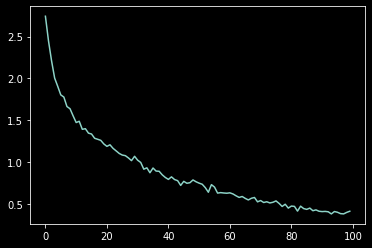

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('dark_background')
plt.figure()
plt.plot(all_losses)

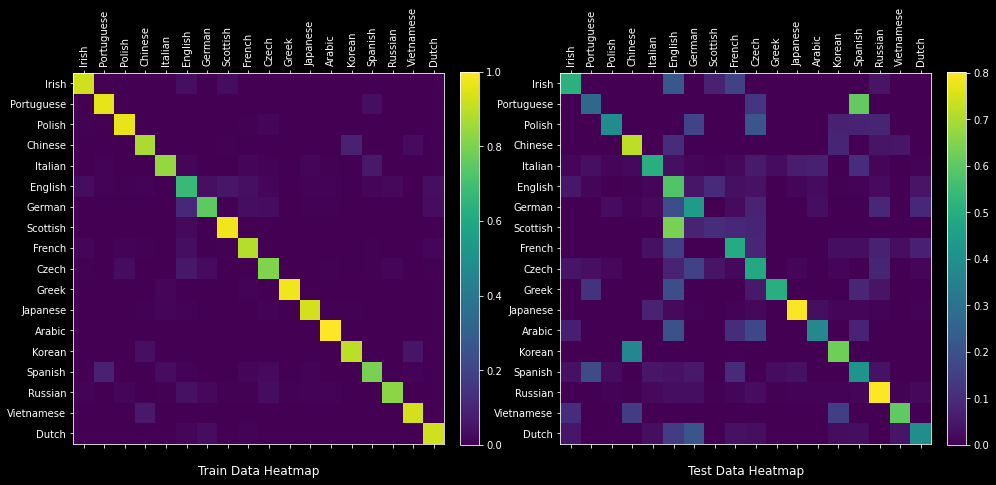

In [62]:

train_confusion = torch.zeros(n_categories, n_categories)
test_confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
def evaluate(line_tensor):
    hidden= rnn.initHidden()

    output, hidden = rnn(line_tensor, hidden)

    return output


fig = plt.figure(figsize=(16,32))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for k,(ax,confusion,category_lines) in enumerate(zip([ax,ax2],[train_confusion,test_confusion],[train_category_lines,test_category_lines])):
        
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomExample(category_lines)
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax,ax=ax,fraction=0.046,pad=0.04)

    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)


    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(False)

    if k ==0:
        ax.set_title("Train Data Heatmap",position=(0.5,-0.1))
    else:
        ax.set_title("Test Data Heatmap",position=(0.5,-0.1))
plt.show()